In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

Age - Age Of The Customer (Возраст клиента)

Government Sector Worker - If The Customer is Employed By The Government Or Not (Является ли клиент сотрудником гос. организации) 

GraduateOrNot - Whether The Customer Is College Graduate Or Not (Есть ли у клиента высшее образование)

AnnualIncome - The Yearly Income Of The Customer In Indian Rupees (Rounded To Nearest 50 Thousand Rupees) (Годовой доход клиента в рупиях)  

FamilyMembers - Number Of Members In Customer's Family (Количество членов семьи клиента)

ChronicDisease - Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthama,etc. (Есть ли у клиента серьезные хронические заболевания)

FrequentFlyer - Derived Data Based On Customer's History Of Booking Air Tickets On Atleast 4 Different Instances In The Last 2 Years (2017-2019). (Бронировал ли клиент как минимум 4 билета на самолет за 2017-19 года)

EverTravelledAbroad - Has The Customer Ever Travelled To A Foreign Country (Not Necessarily Using The Company's Services)  (Был ли клиента когда-нибудь заграницей)

TravelInsurance (1st File Only)- Did The Customer Buy Travel Insurance Package During Introductory Offering  (Брал ли клиент туристическую вводную страховку)

Note: 1=Yes and 0=No

In [2]:
df = pd.read_csv('Travel Company Old Clients.csv', sep=';')

In [3]:
df.head()

,Age,Government Sector Worker,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,1,1,400000,6,1,0,0,0
1,31,0,1,1250000,7,0,0,0,0
2,34,0,1,500000,4,1,0,0,1
3,28,0,1,700000,3,1,0,0,0
4,28,0,1,700000,8,1,1,0,0


Задача заключается в том, чтобы спрогнозировать на новых клиентах будут ли они брать страховки

Для этого я буду использовать несколько методов:
1. Модель логистической регрессии
2. KNN 
3. Random Forest (использовать просто дерево решений не стоит, т.к. очевидно, что случайный лес будет эффективнее)

Для начала в целях удобства преобразую датафрейм

In [4]:
df.rename(columns={'Age':'age',
                  'Government Sector Worker':'gov_sector_worker',
                  'GraduateOrNot':'graduated',
                  'AnnualIncome':'annual_income',
                  'FamilyMembers': 'family_members',
                  'ChronicDiseases': 'chronic_diseases',
                  'FrequentFlyer': 'frequent_flyer',
                  'EverTravelledAbroad': 'travelled_abroad',
                  'TravelInsurance': 'travel_insurance'}, inplace=True)

In [5]:
df.head()

,age,gov_sector_worker,graduated,annual_income,family_members,chronic_diseases,frequent_flyer,travelled_abroad,travel_insurance
0,31,1,1,400000,6,1,0,0,0
1,31,0,1,1250000,7,0,0,0,0
2,34,0,1,500000,4,1,0,0,1
3,28,0,1,700000,3,1,0,0,0
4,28,0,1,700000,8,1,1,0,0


#### EDA:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                682 non-null    int64
 1   gov_sector_worker  682 non-null    int64
 2   graduated          682 non-null    int64
 3   annual_income      682 non-null    int64
 4   family_members     682 non-null    int64
 5   chronic_diseases   682 non-null    int64
 6   frequent_flyer     682 non-null    int64
 7   travelled_abroad   682 non-null    int64
 8   travel_insurance   682 non-null    int64
dtypes: int64(9)
memory usage: 48.1 KB


In [7]:
df.describe()

,age,gov_sector_worker,graduated,annual_income,family_members,chronic_diseases,frequent_flyer,travelled_abroad,travel_insurance
count,682.000000,682.000000,682.000000,6.820000e+02,682.000000,682.000000,682.000000,682.000000,682.000000
mean,29.640762,0.258065,0.850440,9.478006e+05,4.835777,0.280059,0.211144,0.187683,0.337243
std,2.900956,0.437891,0.356901,3.713920e+05,1.622894,0.449357,0.408420,0.390746,0.473116
min,25.000000,0.000000,0.000000,3.000000e+05,2.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,1.000000,6.500000e+05,4.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,0.000000,1.000000,9.500000e+05,5.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,1.000000,1.000000,1.250000e+06,6.000000,1.000000,0.000000,0.000000,1.000000
max,35.000000,1.000000,1.000000,1.800000e+06,9.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.isna().sum()

age                  0
gov_sector_worker    0
graduated            0
annual_income        0
family_members       0
chronic_diseases     0
frequent_flyer       0
travelled_abroad     0
travel_insurance     0
dtype: int64

Наличие выбросов:

несмотря на то, что у всех переменных целочисленный тип данных, не каждая переменная отражает одну суть, существуют количественные переменные как непрерывные, так и дискретные, и есть также номинативные

In [9]:
categorial = ['gov_sector_worker', 'graduated', 'chronic_diseases', 'frequent_flyer', 'travelled_abroad']
numeric = ['age', 'annual_income', 'family_members']

<AxesSubplot:xlabel='family_members'>

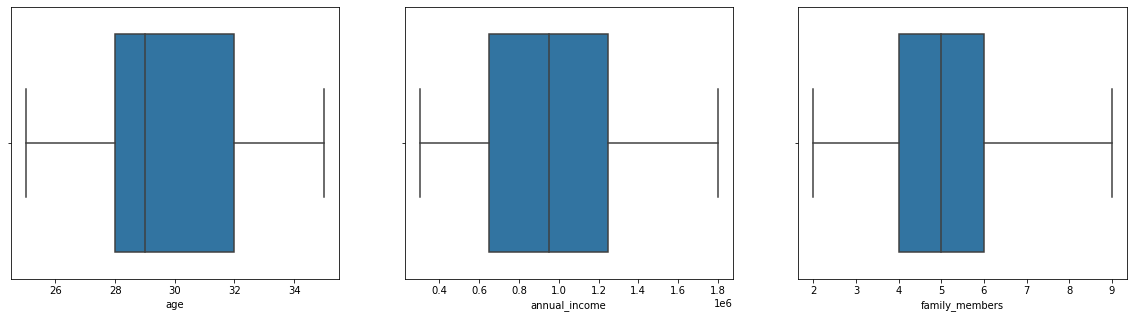

In [10]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

sns.boxplot(data=df, x='age', ax=ax[0])
sns.boxplot(data=df, x='annual_income', ax=ax[1])
sns.boxplot(data=df, x='family_members', ax=ax[2])

из графиков видно, что выбросов нет

Процент людей, кто брал страховку

([<matplotlib.patches.Wedge at 0x20e000538b0>,
 [Text(-0.5382569390286421, 0.9593119761514065, '0'),
  Text(0.5382570288459094, -0.9593119257561505, '1')],
 [Text(-0.29359469401562294, 0.5232610779007671, '66.28%'),
  Text(0.29359474300685967, -0.5232610504124456, '33.72%')])

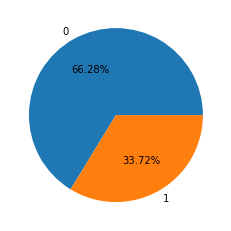

In [11]:
plt.pie(df['travel_insurance'].value_counts(), labels=df['travel_insurance'].value_counts().index, autopct='%.2f%%')

дисбаланс классов хоть и есть, но он не является на столько существенным, чтобы применять методы для несбалансированных классов

Люди какого возраста больше всего брали страховку

<AxesSubplot:xlabel='age', ylabel='count'>

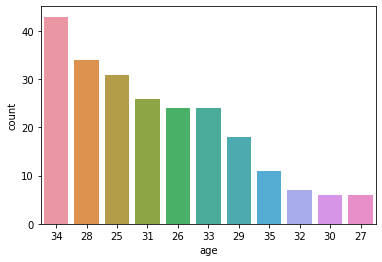

In [12]:
sns.countplot(x=df[df['travel_insurance']==1]['age'], order=df[df['travel_insurance']==1]['age'].value_counts().index)

Как распределен доход тех, кто брал страховку и кто не брал

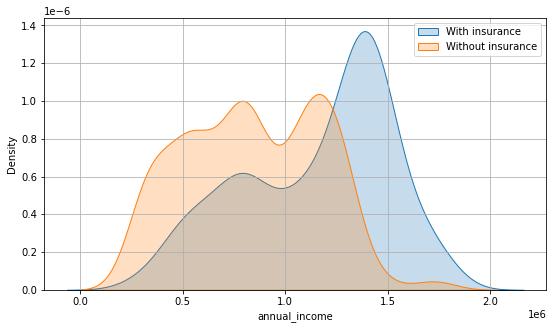

In [13]:
fig, ax = plt.subplots(figsize=(9,5))

ax1 = sns.kdeplot(data=df[df['travel_insurance']==1], x='annual_income', label='With insurance', fill='full')
ax2 = sns.kdeplot(data=df[df['travel_insurance']==0], x='annual_income', label='Without insurance', fill='full')

ax = plt.grid()
ax = plt.legend()

Процентное соотношение людей в зависимости от того были ли они заграницей и брали ли страховку

Text(0.5, 1.0, 'abroad=1   insurance=1')

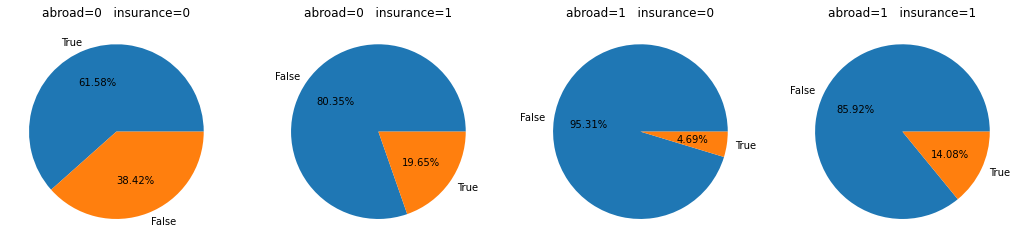

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(18,10))

ax[0].pie(((df['travelled_abroad']==0) & (df['travel_insurance']==0)).value_counts(), labels=((df['travelled_abroad']==0) & (df['travel_insurance']==0)).value_counts().index, autopct='%.2f%%')
ax[1].pie(((df['travelled_abroad']==0) & (df['travel_insurance']==1)).value_counts(), labels=((df['travelled_abroad']==0) & (df['travel_insurance']==1)).value_counts().index, autopct='%.2f%%')
ax[2].pie(((df['travelled_abroad']==1) & (df['travel_insurance']==0)).value_counts(), labels=((df['travelled_abroad']==1) & (df['travel_insurance']==0)).value_counts().index, autopct='%.2f%%')
ax[3].pie(((df['travelled_abroad']==1) & (df['travel_insurance']==1)).value_counts(), labels=((df['travelled_abroad']==1) & (df['travel_insurance']==1)).value_counts().index, autopct='%.2f%%')

ax[0].set_title('abroad=0   insurance=0')
ax[1].set_title('abroad=0   insurance=1')
ax[2].set_title('abroad=1   insurance=0')
ax[3].set_title('abroad=1   insurance=1')

Препроцессинг данных:

In [15]:
X = df.drop(columns='travel_insurance')
y = df['travel_insurance']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((477, 8), (205, 8))

проверка на соотношение классов в обучающей и тестовой выборках

In [17]:
(y_train).sum()/(y_train).count()

0.31865828092243187

In [18]:
(y_test).sum()/(y_test).count()

0.3804878048780488

как видно выше, соотношение можно считать схожим

In [19]:
cols = X_train.columns

данные выражены в разных единицах измерения, поэтому их нужно масштабировать

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

Перед построением моделей можно посмотреть "важность" всех переменных методом главных компонент

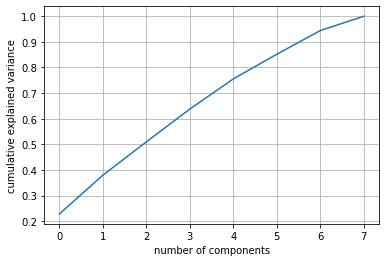

In [22]:
pca_test = PCA(n_components=8)
pca_test.fit(X_train)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()

Из графика видно, что кумулятивная сумма не выходит на асимптоту при имеющемся количестве переменных, хоть и ближе к концу видно затухание, следовательно, все переменные "важны", поэтому построение моделей будет с использованием всех переменных

### Логистическая регрессия:

In [23]:
logist = LogisticRegression(random_state=42)
logist.fit(X_train, y_train)

y_logist = logist.predict(X_test)

некоторые метрики качества для логистической регрессии

<AxesSubplot:>

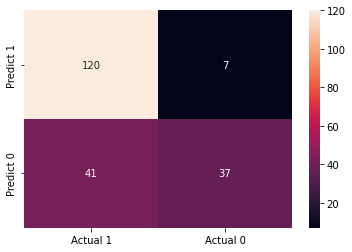

In [24]:
cm_logist = confusion_matrix(y_test, y_logist)

cm_logist_matrix = pd.DataFrame(data=cm_logist, columns=['Actual 1', 'Actual 0'], 
                                                  index=['Predict 1', 'Predict 0'])

sns.heatmap(cm_logist_matrix, annot=True, fmt='d')

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


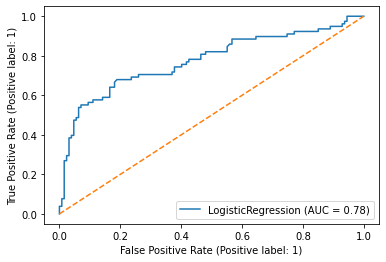

In [25]:
plot_roc_curve(logist, X_test, y_test)
plt.plot([0,1],'--')

вероятность быть первым классом (вероятность того, что клиент возьмет страховку) для первых 10 объектов

In [26]:
logist.predict_proba(X_test)[:10,1]

array([0.13055335, 0.30104973, 0.13340271, 0.80292352, 0.22463721,
       0.27852818, 0.61540077, 0.47514745, 0.08856389, 0.29973746])

### KNN:

сначала построю модель со стандартными параметрами

In [27]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_knn = knn.predict(X_test)

некоторые метрики качества для knn со стандартными параметрами

<AxesSubplot:>

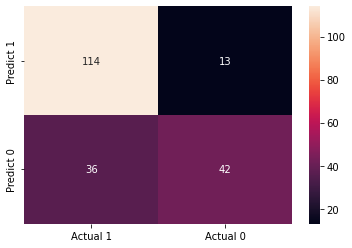

In [28]:
cm_knn = confusion_matrix(y_test, y_knn)

cm_knn_matrix = pd.DataFrame(data=cm_knn, columns=['Actual 1', 'Actual 0'], 
                                            index=['Predict 1', 'Predict 0'])

sns.heatmap(cm_knn_matrix, annot=True, fmt='d')

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


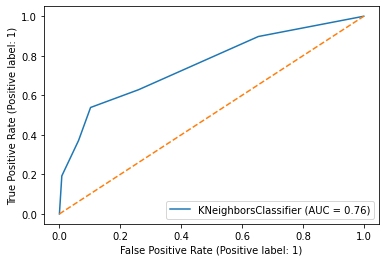

In [29]:
plot_roc_curve(knn, X_test, y_test)
plt.plot([0,1],'--')

In [30]:
knn.predict_proba(X_test)[:10,1]

array([0.2, 0. , 0.2, 1. , 0.8, 0.2, 0.8, 0. , 0.2, 0.4])

Теперь оптимизирую гиперпараметры для модели knn:

для подсчета расстояния весов можно использовать другую функцию, т.к. по умолчанию стоит 1/distance (при этом если расстояние равно 0, то такому объекту дается вес равный 1), буду передавать ее для подбора параметров

In [31]:
def my_weight_dist(dists):
    return 0.5 ** dists

In [32]:
knn_params = {'n_neighbors':np.arange(2,16),
             'weights':['uniform','distance', my_weight_dist]}

In [33]:
rs_knn = GridSearchCV(knn, 
                      param_grid=knn_params, 
                      cv=3)
rs_knn.fit(X_train, y_train)
rs_knn.best_params_

{'n_neighbors': 15, 'weights': <function __main__.my_weight_dist(dists)>}

In [34]:
best_knn = rs_knn.best_estimator_
y_best_knn = best_knn.predict(X_test)

некоторые метрики качества для knn с оптимизированными параметрами

<AxesSubplot:>

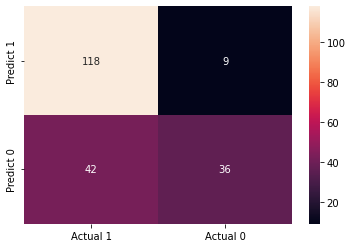

In [35]:
cm_best_knn = confusion_matrix(y_test, y_best_knn)

cm_best_knn_matrix = pd.DataFrame(data=cm_best_knn, columns=['Actual 1', 'Actual 0'], 
                                                      index=['Predict 1', 'Predict 0'])

sns.heatmap(cm_best_knn_matrix, annot=True, fmt='d')

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


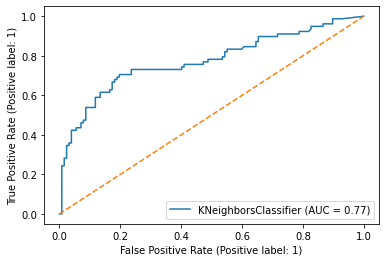

In [36]:
plot_roc_curve(best_knn, X_test, y_test)
plt.plot([0,1],'--')

In [37]:
best_knn.predict_proba(X_test)[:10,1]

array([0.26240531, 0.24864299, 0.08848721, 0.70351734, 0.5006231 ,
       0.19116537, 0.74745098, 0.18227709, 0.07546534, 0.18737236])

### Random Forest:

сначала построю модель со стандартными параметрами

In [38]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

y_forest = forest.predict(X_test)

некоторые метрики качества для леса со стандартными параметрами

<AxesSubplot:>

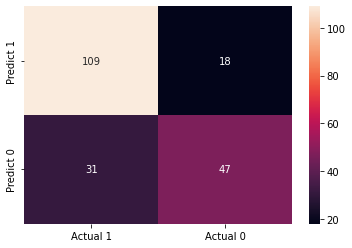

In [39]:
cm_forest = confusion_matrix(y_test, y_forest)

cm_forest_matrix = pd.DataFrame(data=cm_forest, columns=['Actual 1', 'Actual 0'], 
                                                  index=['Predict 1', 'Predict 0'])

sns.heatmap(cm_forest_matrix, annot=True, fmt='d')

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


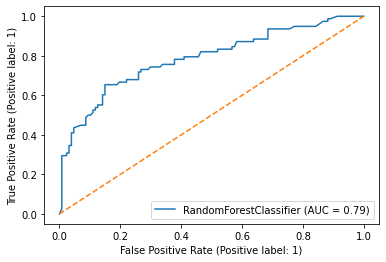

In [40]:
plot_roc_curve(forest, X_test, y_test)
plt.plot([0,1],'--')

In [41]:
forest.predict_proba(X_test)[:10,1]

array([0.19369048, 0.3       , 0.20866667, 0.66      , 0.57      ,
       0.16630952, 0.93      , 0.19      , 0.04      , 0.0685    ])

Теперь оптимизирую гиперпараметры для random forest

In [42]:
forest_params = {'n_estimators': np.arange(50,401,50),
                'criterion':['gini', 'entropy'],
                'max_depth':np.arange(2,6),
                'min_samples_split':np.arange(2,11),
                'min_samples_leaf':np.arange(2,11)}

In [43]:
rs_forest = RandomizedSearchCV(forest, 
                               param_distributions=forest_params, 
                               cv=3, 
                               n_iter=100, 
                               random_state=42)
rs_forest.fit(X_train, y_train)
rs_forest.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'criterion': 'gini'}

In [44]:
rs_forest_df = pd.DataFrame(rs_forest.cv_results_).sort_values('rank_test_score')[['param_n_estimators',
                                                                    'param_criterion',
                                                                    'param_max_depth',
                                                                    'param_min_samples_split',
                                                                    'param_min_samples_leaf',
                                                                    'mean_test_score',
                                                                    'rank_test_score']]

In [45]:
rs_forest_df.head()

,param_n_estimators,param_criterion,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,rank_test_score
22,200,gini,5,10,2,0.823899,1
23,250,entropy,5,9,2,0.821803,2
52,200,entropy,5,3,2,0.819706,3
0,400,entropy,5,10,3,0.817610,4
7,50,entropy,4,7,4,0.817610,4


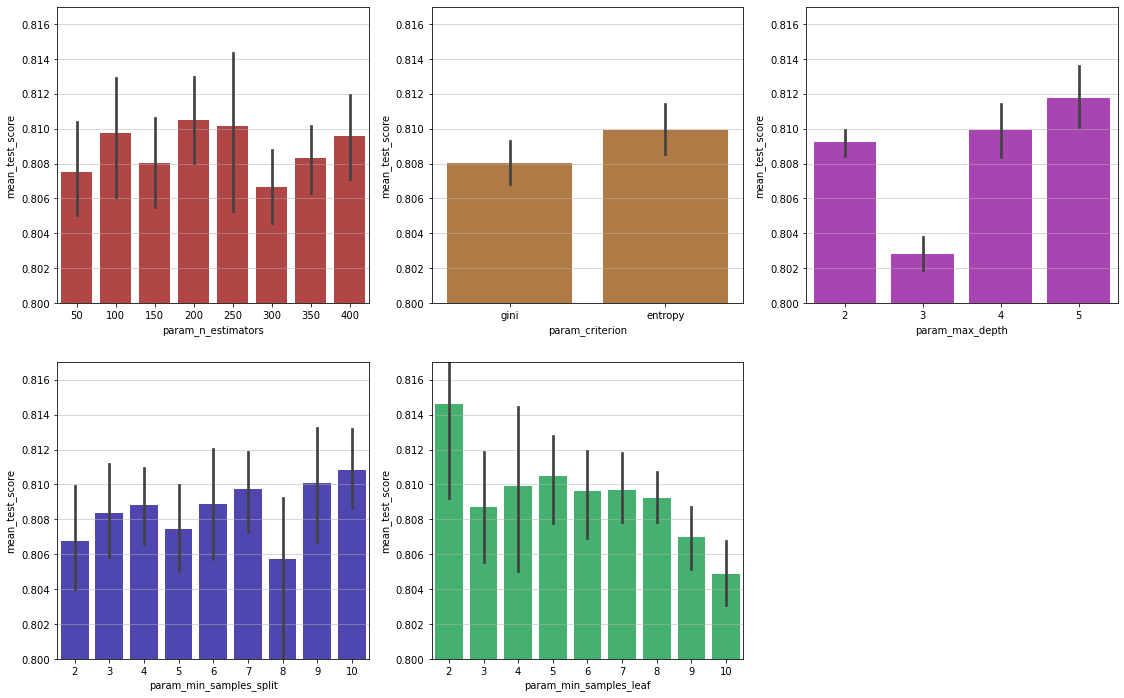

In [46]:
fig, ax = plt.subplots(2,3, figsize=(19,12))

sns.barplot(data=rs_forest_df, x='param_n_estimators', y='mean_test_score', color='#c23434', ax=ax[0,0])
sns.barplot(data=rs_forest_df, x='param_criterion', y='mean_test_score', color='#c27934', ax=ax[0,1])
sns.barplot(data=rs_forest_df, x='param_max_depth', y='mean_test_score', color='#b634c2', ax=ax[0,2])
sns.barplot(data=rs_forest_df, x='param_min_samples_split', y='mean_test_score', color='#4034c2', ax=ax[1,0])
sns.barplot(data=rs_forest_df, x='param_min_samples_leaf', y='mean_test_score', color='#34c26d', ax=ax[1,1])

for axis in ax.ravel():
    axis.set_ylim([0.8,0.817])
    axis.grid(axis='y', linewidth=0.5)

ax[1,2].set_visible(False)

In [47]:
best_forest = rs_forest.best_estimator_
y_best_forest = best_forest.predict(X_test)

некоторые метрики качества для леса с лучшими параметрами, но без oob_score

<AxesSubplot:>

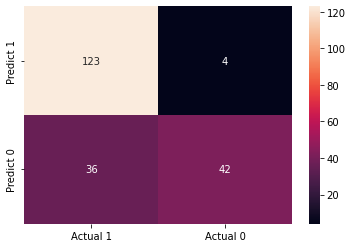

In [48]:
cm_best_forest = confusion_matrix(y_test, y_best_forest)

cm_best_forest_matrix = pd.DataFrame(data=cm_best_forest, columns=['Actual 1', 'Actual 0'], 
                                                  index=['Predict 1', 'Predict 0'])

sns.heatmap(cm_best_forest_matrix, annot=True, fmt='d')

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


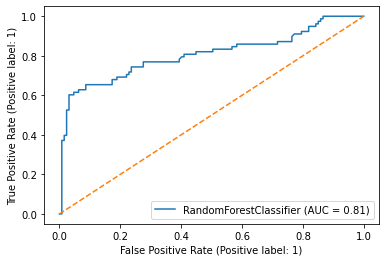

In [49]:
plot_roc_curve(best_forest, X_test, y_test)
plt.plot([0,1],'--')

In [50]:
best_forest.predict_proba(X_test)[:10,1]

array([0.16221945, 0.20203127, 0.13569712, 0.61855249, 0.4580548 ,
       0.20111085, 0.8213055 , 0.20424754, 0.15742661, 0.18181999])

Теперь оптимизирую random forest с параметром oob_score, который можно считать как бы аналогом кросс-валидации

In [51]:
forest_params_oob = {'n_estimators': np.arange(50,401,50),
                'criterion':['gini', 'entropy'],
                'max_depth':np.arange(2,6),
                'min_samples_split':np.arange(2,11),
                'min_samples_leaf':np.arange(2,11),
                'oob_score':[True, False]}

In [52]:
rs_forest_oob = RandomizedSearchCV(forest, 
                               param_distributions=forest_params_oob, 
                               cv=3, 
                               n_iter=100, 
                               random_state=42)
rs_forest_oob.fit(X_train, y_train)
rs_forest_oob.best_params_

{'oob_score': True,
 'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'criterion': 'gini'}

In [53]:
rs_forest_df_oob = pd.DataFrame(rs_forest_oob.cv_results_).sort_values('rank_test_score')[['param_n_estimators',
                                                                    'param_criterion',
                                                                    'param_max_depth',
                                                                    'param_min_samples_split',
                                                                    'param_min_samples_leaf',
                                                                    'param_oob_score',
                                                                    'mean_test_score',
                                                                    'rank_test_score']]

In [54]:
rs_forest_df_oob.head()

,param_n_estimators,param_criterion,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_oob_score,mean_test_score,rank_test_score
38,100,gini,5,2,2,True,0.823899,1
27,400,entropy,5,7,2,False,0.819706,2
58,200,gini,5,5,2,False,0.819706,2
54,100,entropy,4,3,5,True,0.817610,4
95,200,gini,4,8,2,False,0.817610,4


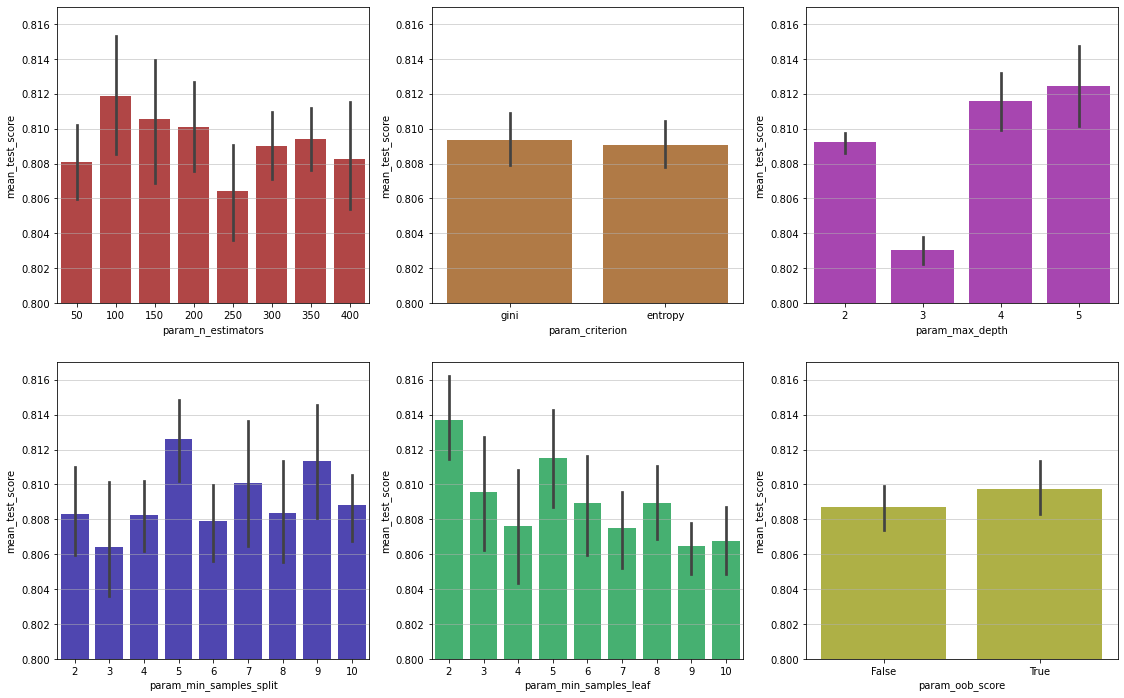

In [55]:
fig, ax = plt.subplots(2,3, figsize=(19,12))

sns.barplot(data=rs_forest_df_oob, x='param_n_estimators', y='mean_test_score', color='#c23434', ax=ax[0,0])
sns.barplot(data=rs_forest_df_oob, x='param_criterion', y='mean_test_score', color='#c27934', ax=ax[0,1])
sns.barplot(data=rs_forest_df_oob, x='param_max_depth', y='mean_test_score', color='#b634c2', ax=ax[0,2])
sns.barplot(data=rs_forest_df_oob, x='param_min_samples_split', y='mean_test_score', color='#4034c2', ax=ax[1,0])
sns.barplot(data=rs_forest_df_oob, x='param_min_samples_leaf', y='mean_test_score', color='#34c26d', ax=ax[1,1])
sns.barplot(data=rs_forest_df_oob, x='param_oob_score', y='mean_test_score', color='#bfc234', ax=ax[1,2])

for axis in ax.ravel():
    axis.set_ylim([0.8,0.817])
    axis.grid(axis='y', linewidth=0.5)

In [56]:
best_forest_oob = rs_forest_oob.best_estimator_
y_best_forest_oob = best_forest_oob.predict(X_test)

некоторые метрики качества для леса с лучшими параметрами с oob_score

<AxesSubplot:>

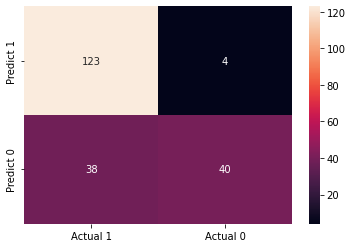

In [57]:
cm_best_forest_oob = confusion_matrix(y_test, y_best_forest_oob)

cm_best_forest_oob_matrix = pd.DataFrame(data=cm_best_forest_oob, columns=['Actual 1', 'Actual 0'], 
                                                  index=['Predict 1', 'Predict 0'])

sns.heatmap(cm_best_forest_oob_matrix, annot=True, fmt='d')

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


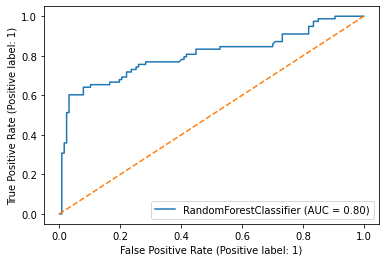

In [58]:
plot_roc_curve(best_forest_oob, X_test, y_test)
plt.plot([0,1],'--')

In [59]:
best_forest_oob.predict_proba(X_test)[:10,1]

array([0.1701527 , 0.22022977, 0.12991355, 0.60099394, 0.46788038,
       0.21674702, 0.83888276, 0.20719194, 0.14845929, 0.1808202 ])

можно посмотреть в скольких объектах лес с oob параметром и лес без него дали разные предсказания

In [60]:
sum((y_best_forest==y_best_forest_oob)==False)

2

судя по этому числу, можно сказать, что используя oob, разница в предсказаниях небольшая

Хотя уже и ясно, что все параметры важны, можно посмотреть в какой степени этот параметр важен.  
Сделаю это для каждого леса

In [61]:
forest_importances = pd.DataFrame({'feature':X_test.columns,
                                   'gini_importance_forest':forest.feature_importances_}) \
                                   .sort_values('gini_importance_forest', ascending=False)

best_forest_importances = pd.DataFrame({'feature':X_test.columns,
                                        'gini_importance_best_forest':best_forest.feature_importances_}) \
                                        .sort_values('gini_importance_best_forest', ascending=False)

best_forest_oob_importances = pd.DataFrame({'feature':X_test.columns,
                                            'gini_importance_best_forest_oob':best_forest_oob.feature_importances_}) \
                                            .sort_values('gini_importance_best_forest_oob', ascending=False)

In [62]:
all_importances = forest_importances.merge(best_forest_importances).merge(best_forest_oob_importances)

In [63]:
all_importances

,feature,gini_importance_forest,gini_importance_best_forest,gini_importance_best_forest_oob
0,annual_income,0.417929,0.459750,0.488500
1,family_members,0.191798,0.089209,0.098105
2,age,0.185966,0.152829,0.149730
3,travelled_abroad,0.084259,0.197004,0.168479
4,chronic_diseases,0.037636,0.020210,0.016727
5,frequent_flyer,0.034577,0.035755,0.033300
6,gov_sector_worker,0.026189,0.027697,0.025219
7,graduated,0.021645,0.017545,0.019940


In [64]:
all_importances_melted = pd.melt(all_importances, 
                                 id_vars='feature', 
                                 value_vars=['gini_importance_forest',
                                             'gini_importance_best_forest',
                                             'gini_importance_best_forest_oob']) \
                                 .rename(columns={'variable':'type'})

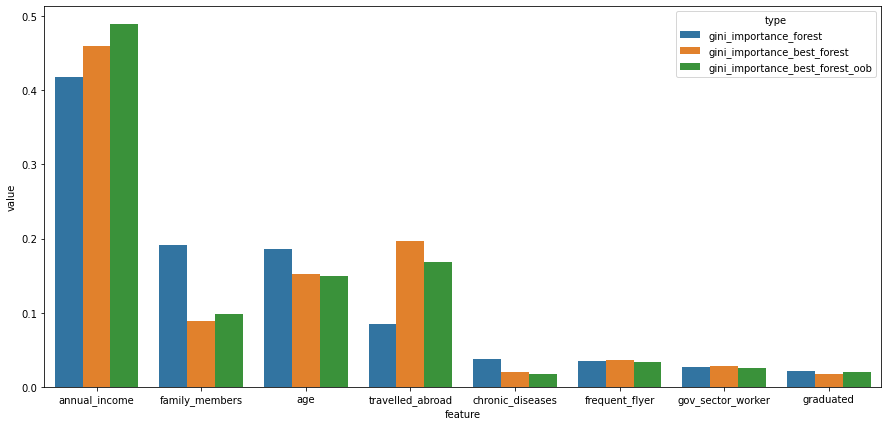

In [65]:
fig, ax = plt.subplots(figsize=(15,7))

ax = sns.barplot(data=all_importances_melted, x='feature', y='value', hue='type')

Также для грубой оценки важности признаков можно использовать коэффициенты логистической регрессии

In [66]:
logist_importances = pd.DataFrame({'feature':X_test.columns,
                                   'importance':logist.coef_[0]}) \
                                   .sort_values('importance', ascending=False)

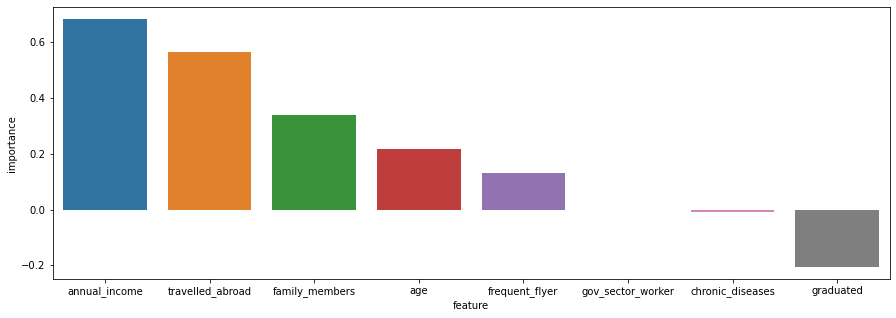

In [67]:
fig, ax = plt.subplots(figsize=(15,5))

ax = sns.barplot(data=logist_importances, x='feature', y='importance')

Атрибуты 'важности' признаков как для логистической регрессии, так и для случайного леса говорят об этой самой 'важности' признаков для модели в целом. Для модели knn таких атрибутов не существует, для нее можно узнать 'важность' лишь для предсказываемых значений

In [68]:
all_metrics = pd.DataFrame({'model':['logist','knn','best_knn','forest','best_forest','best_forest_oob'],
             'accuracy':[accuracy_score(y_test,y_logist),
                        accuracy_score(y_test,y_knn),
                        accuracy_score(y_test,y_best_knn),
                        accuracy_score(y_test,y_forest),
                        accuracy_score(y_test,y_best_forest),
                        accuracy_score(y_test,y_best_forest_oob)],
             'precision':[precision_score(y_test,y_logist),
                         precision_score(y_test,y_knn),
                         precision_score(y_test,y_best_knn),
                         precision_score(y_test,y_forest),
                         precision_score(y_test,y_best_forest),
                         precision_score(y_test,y_best_forest_oob)],
             'recall':[recall_score(y_test,y_logist),
                      recall_score(y_test,y_knn),
                      recall_score(y_test,y_best_knn),
                      recall_score(y_test,y_forest),
                      recall_score(y_test,y_best_forest),
                      recall_score(y_test,y_best_forest_oob)],
             'f1_score':[f1_score(y_test,y_logist),
                        f1_score(y_test,y_knn),
                        f1_score(y_test,y_best_knn),
                        f1_score(y_test,y_forest),
                        f1_score(y_test,y_best_forest),
                        f1_score(y_test,y_best_forest_oob)],
             'roc_auc':[roc_auc_score(y_test,y_logist),
                       roc_auc_score(y_test,y_knn),
                       roc_auc_score(y_test,y_best_knn),
                       roc_auc_score(y_test,y_forest),
                       roc_auc_score(y_test,y_best_forest),
                       roc_auc_score(y_test,y_best_forest_oob)]})
all_metrics

,model,accuracy,precision,recall,f1_score,roc_auc
0,logist,0.765854,0.840909,0.474359,0.606557,0.709620
1,knn,0.760976,0.763636,0.538462,0.631579,0.718050
2,best_knn,0.751220,0.800000,0.461538,0.585366,0.695336
3,forest,0.760976,0.723077,0.602564,0.657343,0.730416
4,best_forest,0.804878,0.913043,0.538462,0.677419,0.753483
5,best_forest_oob,0.795122,0.909091,0.512821,0.655738,0.740662


В данной задаче можно считать, что в равной степени важны как ложные срабатывания, так и ложные пропуски, поэтому буду выбирать лучшую модель по метрике roc-auc

Для прогнозирования выбираю модель с максимальным roc-auc - это модель best_forest

In [69]:
df_new = pd.read_csv('Travel Company New Clients.csv', sep=';')

In [70]:
df_new

,Age,Government Sector Worker,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
0,25,0,0,1150000,4,0,0,0
1,34,0,1,1500000,4,1,1,1
2,33,0,1,1500000,3,0,1,1
3,28,0,1,1150000,3,0,0,0
4,33,1,1,400000,5,1,0,0
...,...,...,...,...,...,...,...,...
1298,33,0,1,1500000,4,0,1,1
1299,28,0,1,1750000,5,1,0,1
1300,28,0,1,1150000,6,1,0,0
1301,34,0,1,1000000,6,0,1,1


In [71]:
df_new.rename(columns={'Age':'age',
                  'Government Sector Worker':'gov_sector_worker',
                  'GraduateOrNot':'graduated',
                  'AnnualIncome':'annual_income',
                  'FamilyMembers': 'family_members',
                  'ChronicDiseases': 'chronic_diseases',
                  'FrequentFlyer': 'frequent_flyer',
                  'EverTravelledAbroad': 'travelled_abroad',
                  'TravelInsurance': 'travel_insurance'}, inplace=True)

In [72]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                1303 non-null   int64
 1   gov_sector_worker  1303 non-null   int64
 2   graduated          1303 non-null   int64
 3   annual_income      1303 non-null   int64
 4   family_members     1303 non-null   int64
 5   chronic_diseases   1303 non-null   int64
 6   frequent_flyer     1303 non-null   int64
 7   travelled_abroad   1303 non-null   int64
dtypes: int64(8)
memory usage: 81.6 KB


Проверка на наличие выбросов

In [73]:
df_new.isna().sum()

age                  0
gov_sector_worker    0
graduated            0
annual_income        0
family_members       0
chronic_diseases     0
frequent_flyer       0
travelled_abroad     0
dtype: int64

Сделаю копию данных, т.к. при стандартизации данные приводятся в тип float, при обратной стандартизации этот тип данных сохраняется, а если приводить его к изначальному типу данных (int), то могут быть потери в данных

In [74]:
df_new_copy = df_new.copy()

In [75]:
cols_new = df_new_copy.columns

Теперь буду масштабировать копию данных и на них делать предсказание

In [76]:
df_new_scaled = pd.DataFrame(scaler.transform(df_new_copy), columns=cols)

In [77]:
predictions_new_clients = best_forest.predict(df_new_scaled)

А добавлять предсказания я буду в оригинальный датафрейм

In [78]:
df_new['predicted_travel_insurance'] = predictions_new_clients

Сохраню файл для последующего построения дэшборда

In [79]:
# df_new.to_excel('predictions_for_new_clients.xlsx')